# Importazione delle librerie

In [28]:
import re
import tweepy
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import csv
import string
from tweepy import OAuthHandler
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from emot.emo_unicode import EMOJI_UNICODE

# Tweets mining

In [29]:
# keys e tokens dalla Twitter Dev Console
consumer_key = 'XXXXXXXXXXXXXXXX'
consumer_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_token = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_token_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

In [30]:
# prova di autenticazione
try:
	# creazione dell'oggetto OAuthHandler
	auth = OAuthHandler(consumer_key, consumer_secret)
	# impostazione dell'access token e del secret
	auth.set_access_token(access_token, access_token_secret)
	# creazione dell'oggetto API tweepy per il fetch dei tweet
	api = tweepy.API(auth)
except:
	print("Error: Authentication Failed")

## Creazione delle funzione necessaria al mining dei tweet

In questa sezione viene creata la funzione necessaria ad estrarre i tweet da Twitter mediante l'oggetto Cursor di Tweepy. In seguito, i tweet e i parametri a loro associati vengono aggiunti nel file "tweets.csv" per una gestione più modulare.

In [31]:
def get_tweets(query, count = 10):
	
	# lista vuota per conservare i tweet
	tweets_list = [tweets for tweets in tweepy.Cursor(api.search, q=query, lang="en", tweet_mode='extended').items(count)]

	# scraping dei singoli tweet e scrittura del file tweets.csv
	with open('tweets.csv', 'a', newline='', encoding='utf-8') as csvFile:
		column_names = ['tweet_id', 'text', 'retweet', 'likes']
		csv_writer = csv.DictWriter(csvFile, fieldnames=column_names, delimiter=',')
		csv_writer.writeheader()
		for tweet in tweets_list[::-1]:
			csv_data = {}
			csv_data['tweet_id'] = tweet.id
			csv_data['text'] = tweet.full_text
			csv_data['retweet'] = tweet.retweet_count
			csv_data['likes'] = tweet.favorite_count
			csv_writer.writerow(csv_data)

# utilizzo della funzione per estrarre i tweet secondo la query in questione
get_tweets(query= 'climate change', count = 1250)

## Utilizzo del Pandas Dataframe per gestire i tweet estratti all'interno del progetto

In [32]:
tweets = []

# creazione del DataFrame dal file csv
df = pd.read_csv('tweets.csv', index_col=None, header=0)
tweets.append(df)

tweets_df = pd.concat(tweets, axis=0, ignore_index=True)

tweets_df.head()

,tweet_id,text,retweet,likes
0,1442029494970114048,RT @smitajs: Apt ! Don't talk about climate ch...,13,0
1,1442029504277319688,Vanuatu to seek international court opinion on...,0,1
2,1442029509113352198,Wildfires in California have now become routin...,0,0
3,1442029514251374595,@INTERPOL_HQ HUMAN RIGHTS AND CLIMATE CHANGE.....,0,0
4,1442029520995770379,"RT @mankabTOI: ""Climate Change action should s...",144,0


## Controlli e ottimizzazioni sul Dataframe

In [33]:
tweets_df.shape #controllo delle dimensioni del dataframe

(1250, 4)

In [34]:
tweets_df.duplicated(subset='tweet_id').sum() # controllo su valori duplicati (in base all'id)

0

In [35]:
tweets_df = tweets_df.drop_duplicates(subset=['tweet_id']) # eliminazione di valori duplicati

In [36]:
tweets_df.shape # nuovo controllo delle dimensioni

(1250, 4)

# Processazione dei tweet

Il testo dei tweet contiene molti elementi fuorvianti e inutili in fase di analisi. Qui sotto ci sono alcune funzioni necessarie a ripulirli e ad estrarre solo parti interessanti da analizzare successivamente.

In [37]:
# definizione delle variabili dai moduli nltk necessari alla processazione
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase)
stop_words = stop_words + alphabets
word_list = words.words()
emojis = list(EMOJI_UNICODE.keys())

In [38]:
# definizione della funzione necessaria ad eliminare link, caratteri speciali, stopwords,
# emoji, punteggiatura dal testo del tweet e a tokenizzarlo
def process_tweets(tweet):

    tweet = tweet.lower()

    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)

    tweet = re.sub(r'\@\w+|\#|\d+', '', tweet)

    tweet_tokens = word_tokenize(tweet)

    filtered_words = [w for w in tweet_tokens if w not in stop_words]
    filtered_words = [w for w in filtered_words if w not in emojis]
    filtered_words = [w for w in filtered_words if w in word_list]

    no_punc_words = [char for char in filtered_words if char not in string.punctuation]
    no_punc_words = ' '.join(no_punc_words)

    return "".join(no_punc_words)

In [39]:
# definizione della funzione necessaria ad estrarre gli aggettivi dal testo del tweet
def get_adjectives(tweet):
    tweet = word_tokenize(tweet)
    tweet = [word for (word, tag) in pos_tag(tweet)
        if tag == "JJ"]
    return " ".join(tweet)

In [40]:
# aggiunta colonna tweet processati al DataFrame
tweets_df['processed tweets'] = tweets_df['text'].apply(process_tweets)

In [41]:
# aggiunta colonna aggettivi al DataFrame
tweets_df['tweets adjectives'] = tweets_df['processed tweets'].apply(get_adjectives)

In [42]:
tweets_df.head()

,tweet_id,text,retweet,likes,processed tweets,tweets adjectives
0,1442029494970114048,RT @smitajs: Apt ! Don't talk about climate ch...,13,0,apt talk climate change mouthful animal,apt
1,1442029504277319688,Vanuatu to seek international court opinion on...,0,1,seek international court opinion climate change,seek international
2,1442029509113352198,Wildfires in California have now become routin...,0,0,become routine insurance suffering huge disast...,routine huge due
3,1442029514251374595,@INTERPOL_HQ HUMAN RIGHTS AND CLIMATE CHANGE.....,0,0,human climate change end corruption drug carte...,human truth china
4,1442029520995770379,"RT @mankabTOI: ""Climate Change action should s...",144,0,climate change action start state environment ...,


In [43]:
# definizione della funzione che usa il lemmatizer per riportare le parole dei tweet alla loro forma base
def lemmatize_tweets(tweet):
    tweet_tokens = word_tokenize(tweet)
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w) for w in tweet_tokens]
    return " ".join(lemma_words)

In [44]:
# aggiunta colonna tweet 'lemmatizzati' al DataFrame
tweets_df['lemmatized tweets'] = tweets_df['processed tweets'].apply(lemmatize_tweets)

In [45]:
tweets_df.head()

,tweet_id,text,retweet,likes,processed tweets,tweets adjectives,lemmatized tweets
0,1442029494970114048,RT @smitajs: Apt ! Don't talk about climate ch...,13,0,apt talk climate change mouthful animal,apt,apt talk climate change mouthful animal
1,1442029504277319688,Vanuatu to seek international court opinion on...,0,1,seek international court opinion climate change,seek international,seek international court opinion climate change
2,1442029509113352198,Wildfires in California have now become routin...,0,0,become routine insurance suffering huge disast...,routine huge due,become routine insurance suffering huge disast...
3,1442029514251374595,@INTERPOL_HQ HUMAN RIGHTS AND CLIMATE CHANGE.....,0,0,human climate change end corruption drug carte...,human truth china,human climate change end corruption drug carte...
4,1442029520995770379,"RT @mankabTOI: ""Climate Change action should s...",144,0,climate change action start state environment ...,,climate change action start state environment ...


# Sentiment Analysis

In questa fase viene fatta la sentiment analysis vera e propria tramite TextBlob, che sfrutta il machine learning per determinare la polarità dei tweet forniti su una scala da -1 (negativi) a 1 (positivi), passando per 0 (neutrali).

In [46]:
# definizione delle funzioni necessarie a calcolare la polarità e il sentiment dei tweet da TextBlob
def get_polarity(tweet):
    return TextBlob(tweet).sentiment.polarity

def get_sentiment(polarity):
    if polarity < 0:
        return "Negative"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Positive"

In [47]:
# aggiunta colonne polarità e sentiment al DataFrame
tweets_df['polarity'] = tweets_df['lemmatized tweets'].apply(get_polarity)
tweets_df['sentiment'] = tweets_df['polarity'].apply(get_sentiment)

In [48]:
# DataFrame per il conteggio dei tweet positivi, neutrali e negativi
sentiment = tweets_df['sentiment'].value_counts().rename_axis('sentiment').to_frame('total tweets').reset_index()
sentiment

,sentiment,total tweets
0,Neutral,571
1,Positive,447
2,Negative,232


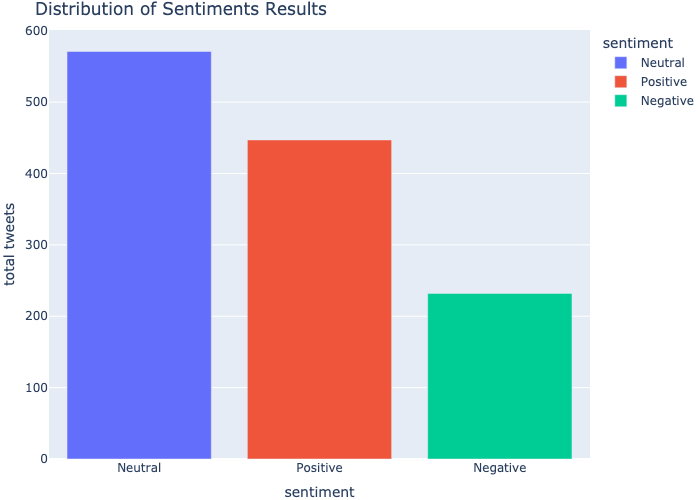

In [49]:
# creazione del grafico della distribuzione dei tweet positivi, neutrali e negativi
sentiment_barchart = px.bar(sentiment, x = 'sentiment', y='total tweets', color='sentiment')

sentiment_barchart.update_layout(title='Distribution of Sentiments Results',
                                  margin={"r": 0, "t": 30, "l": 0, "b": 0})

sentiment_barchart.show(renderer='png')

In [50]:
# creazione stringa con gli aggettivi estratti dai tweet
tweets_string = tweets_df['tweets adjectives'].tolist()
tweets_string = " ".join(tweets_string)

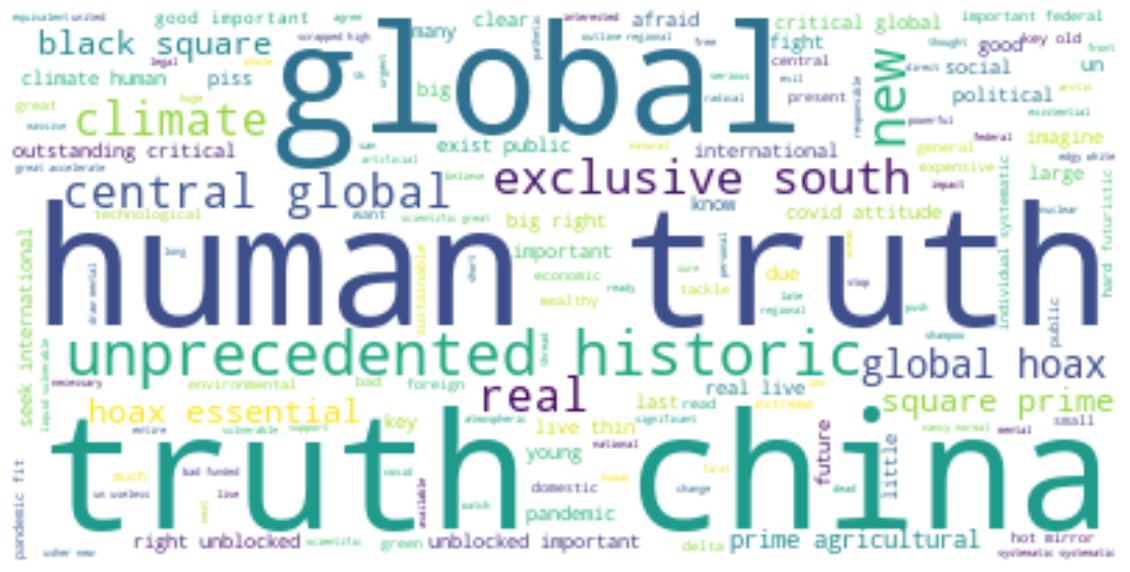

In [51]:
# creazione della WordCloud contenente gli aggettivi più utilizzati
wc = WordCloud(background_color='white', max_words=1500)

# generazione della WordCloud
wc.generate(tweets_string)

# impostazioni per mostrare la WordCloud
fig = plt.figure()
fig.set_figwidth(20)  # impostazione larghezza
fig.set_figheight(20)  # impostazione altezza

plt.imshow(wc.recolor(random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

In [52]:
# creazione lista con gli aggettivi più utilizzati
tweets_string = tweets_df['tweets adjectives'].tolist()
tweets_list=[]
for item in tweets_string:
    item = item.split()
    for i in item:
        tweets_list.append(i)

In [53]:
# uso del modulo collections per contare gli aggettivi
from collections import Counter
counts = Counter(tweets_list)

# creazione del DataFrame con aggettivo e numero di occorrenze ordinato per numero di occorrenze discendente
df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df.columns = ['words', 'count']
df.sort_values(by='count', ascending=False, inplace=True)

In [54]:
df.head(10)

,words,count
50,global,129
6,human,97
8,china,80
7,truth,78
9,unprecedented,46
10,historic,46
37,new,43
36,climate,40
11,important,35
12,real,34
